In [19]:
import logging
import threading
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline

2019-09-27T20:10:10.575 DEBUG matplotlib.pyplot.switch_backend Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [4]:
credentials = {
  "tenantId": "AnalyticsServiceDev",
  "as_api_host": "https://api-dev.connectedproducts.internetofthings.ibmcloud.com",
  "as_api_key": "a-69xgm4-8bdgtvnsv4",
  "as_api_token": "9X_tMKdupOiJ!mzaPV",
  "config" : {
      "objectStorageEndpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net",
      "bos_runtime_bucket" : "analytics-runtime-analyticsservicedev-799d2008b460",
      "bos_logs_bucket" : "analytics-logs-analyticsservicedev-32703c52ec8b"
  },
  "objectStorage": {
      "username" : "58ddd86b5de8468b819d385046f17033",
      "password" : "ee0d6c5521ce9ff100f91b0e37d4eb8cc1a038b5a6d05b38",
      "region" : "us",
      "endpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net"
  },
  "db2": {
    "username": "bluadmin",
    "password": "ZmM5MmE5NmZkZGZl",
    "databaseName": "BLUDB",
    "port": 50000,
    "httpsUrl": "https://dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net:50000",
    "host": "dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net"
  }
}
EngineLogging.configure_console_logging(logging.DEBUG)

2019-09-27T19:28:06.880 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10


In [5]:
db_schema = None
db = Database(credentials=credentials)
print (db)

2019-09-27T19:28:26.080 DEBUG iotfunctions.db.__init__ Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2019-09-27T19:28:26.081 DEBUG iotfunctions.db.__init__ created a CosClient object
2019-09-27T19:28:28.727 DEBUG iotfunctions.db.__init__ Db connection established
2019-09-27T19:28:28.729 DEBUG urllib3.connectionpool._new_conn Starting new HTTPS connection (1): api-dev.connectedproducts.internetofthings.ibmcloud.com


/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


2019-09-27T19:28:33.090 DEBUG urllib3.connectionpool._make_request https://api-dev.connectedproducts.internetofthings.ibmcloud.com:443 "GET /api/meta/v1/AnalyticsServiceDev/entityType HTTP/1.1" 200 None
2019-09-27T19:28:33.628 DEBUG iotfunctions.db.http_request http request successful. status 200


In [7]:
table = db.get_table("KERAS_MODEL")
start_ts = dt.datetime.utcnow() - dt.timedelta(days=30)
end_ts = dt.datetime.utcnow()
df = db.read_table(table, None, None, None, "evt_timestamp", start_ts, end_ts)
print (table)
print (df.shape)


KERAS_MODEL
(277690, 9)


In [11]:
print (df.head(5))

  deviceid              evt_timestamp   devicetype logicalinterface_id format  \
0    73003 2019-08-28 17:30:00.023703  keras_model                              
1    73003 2019-08-28 17:30:01.118874  keras_model                              
2    73002 2019-08-28 17:34:38.586213  keras_model                              
3    73001 2019-08-28 17:34:39.419629  keras_model                              
4    73001 2019-08-28 17:34:37.567116  keras_model                              

  updated_utc     speed      temp  pressure  
0        None -0.508825  0.445147 -2.195758  
1        None -0.612715  0.073735  0.738584  
2        None  0.003322 -0.389620  0.296189  
3        None  0.956136  2.266419  1.318365  
4        None -0.188706  1.572139 -0.755207  


2019-09-27T19:35:35.360 DEBUG matplotlib.font_manager._findfont_cached findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2019-09-27T19:35:35.361 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 0.33499999999999996
2019-09-27T19:35:35.362 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-09-27T19:35:35.362 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:35.363 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.364 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans Display' (DejaVuS

2019-09-27T19:35:35.394 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Not Quite Right BRK' (notqr.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.395 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MPH 2B Damase' (damase.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.396 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.397 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'RobotoRegular' (Roboto-Regular.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.399 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:35.399 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-ExtraCondensedLight.tt

2019-09-27T19:35:35.432 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Binary X 01s BRK' (binx01s.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.433 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:35.433 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Colourbars' (colourba.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.434 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Sad Films' (sadfilms.ttf) normal normal 700 normal>) = 10.335
2019-09-27T19:35:35.435 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-SemiCondensedItalic.ttf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:35.435 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vigilance BRK' (vigilanc.ttf) 

2019-09-27T19:35:35.472 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-CondensedSemiBoldItalic.ttf) italic normal semibold condensed>) = 11.44
2019-09-27T19:35:35.473 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'ITC Lubalin Graph Std' (LubalinGraphStd-ExtraLightObl.otf) oblique normal light normal>) = 11.24
2019-09-27T19:35:35.473 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Frank Ruehl CLM' (FrankRuehlCLM-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-09-27T19:35:35.474 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cabin' (Cabin-SemiBoldItalic.otf) italic normal semibold normal>) = 11.24
2019-09-27T19:35:35.475 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:35.475 DEBUG matplotlib.font_manager._findfont_cached fin

2019-09-27T19:35:35.506 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Home Sweet Home' (homeswee.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.507 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Chorus' (texgyrechorus-mediumitalic.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.508 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-Roman.otf) normal normal roman normal>) = 10.145
2019-09-27T19:35:35.508 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_WinChrome' (MathJax_WinChrome-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:35.509 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gentium Basic' (GenBasR.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.509 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Carlito' (Carlito-Bold.ttf) normal nor

2019-09-27T19:35:35.536 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Beat My Guest' (beatmygu.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.537 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Qlumpy BRK' (qlumpy.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.537 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Goose Bumps BRK' (gosebmps.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.538 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Relish Gargler' (relishga.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.539 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.539 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Turkish Participants' (turkp___.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.5

2019-09-27T19:35:35.579 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Serif' (cmunrm.ttf) normal normal roman normal>) = 10.145
2019-09-27T19:35:35.580 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:35.581 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Paint Boy' (paintboy.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.582 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dash Dot BRK' (dashdot.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.582 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Romande ADF Std' (RomandeADFStd-Italic.otf) italic normal roman normal>) = 11.145
2019-09-27T19:35:35.583 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Corpulent Caps Shadow BRK' (ccapshad.ttf) normal norma

2019-09-27T19:35:35.609 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:35.609 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:35.610 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Kesme' (UKIJKesme.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.611 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fatboy Slim BLTC 2 BRK' (fbsbltc2.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.612 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:35.613 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif

2019-09-27T19:35:35.641 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:35.642 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:35.642 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hand Me Down O BRK' (handmedo.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.643 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:35.644 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'False Positive BRK' (falsepos.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.644 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tuz Tor' (UK

2019-09-27T19:35:35.681 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Mono Prop' (lmmonoprop10-oblique.otf) oblique normal 400 normal>) = 11.05
2019-09-27T19:35:35.682 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tuz Qara' (UKIJTuzQB.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:35.682 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Canadian Aboriginal' (NotoSansCanadianAboriginal-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:35.683 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:35.684 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Excelsior GPL&GNU' (BPG_Excelsior_GPL&GNU.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.685 DEBUG matplotlib.font_manager._findfont_ca

2019-09-27T19:35:35.747 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-CondensedExtraLightItalic.ttf) italic normal light condensed>) = 11.44
2019-09-27T19:35:35.747 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BetecknaGSCondensed' (BetecknaGSCondensed-Bold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:35.748 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-ExtraCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:35.749 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quill Experimental O BRK' (quillexo.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.749 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dark Side BRK' (darkside.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.750 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 

2019-09-27T19:35:35.782 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:35.783 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-Condensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:35.783 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CLAW 1 BRK' (claw1.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.784 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pneumatics BRK' (pneumati.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.785 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:35.786 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu Mono derivative P

2019-09-27T19:35:35.815 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:35.816 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:35.816 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Bengali' (NotoSansBengali-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:35.817 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hadasim CLM' (HadasimCLM-RegularOblique.ttf) oblique normal regular normal>) = 11.05
2019-09-27T19:35:35.817 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Amiri' (Amiri-BoldSlanted.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:35.818 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Se

2019-09-27T19:35:35.843 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-ExtraBold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:35.844 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-Bold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:35.844 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lato' (Lato-ThinItalic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:35.845 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Guseul' (Guseul.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.846 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gillius ADF No2' (GilliusADFNo2-CondItalic.otf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:35.846 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'ITC Lubalin Graph Std' (LubalinGraphStd-ExtraLight.otf) normal normal light no

2019-09-27T19:35:35.875 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'API  PHON?TIQUE' (apibold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:35.876 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Shifty Chica' (shifty.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.877 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Binary X CHR BRK' (binxchr.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.877 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-CondensedExtraBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-09-27T19:35:35.878 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Modi' (NotoSansModi-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:35.879 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TSCu_Paranar' (TSCu_paranari.ttf) italic normal 400 normal>) = 11.

2019-09-27T19:35:35.951 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:35.952 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-SemiCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:35.953 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:35.954 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Petra' (ae_Petra.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.955 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Devanagari' (NotoSerifDevanagari-Regular.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.956 DEBUG matplotlib.font_manager.

2019-09-27T19:35:35.986 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:35.987 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Carlito' (Carlito-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:35.988 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Kaliber Round BRK' (kaliberr.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.989 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Jigsaw Trouserdrop' (jigsawtr.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:35.989 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Larabiefont' (larabieb.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:35.990 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Off Kilter R BRK' (offkiltr.ttf) normal normal 400 normal>

2019-09-27T19:35:36.016 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Entangled Layer A BRK' (entlayra.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.017 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:36.017 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Embossing Tape 2 BRK' (embosst2.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.018 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-LtCnO.otf) oblique normal light condensed>) = 11.44
2019-09-27T19:35:36.020 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Sulus' (UKIJSls.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.021 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu Mono derivative Powerline' (Ubu

2019-09-27T19:35:36.052 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Nino Medium Cond GPL&GNU' (BPG_Nino_Medium_Cond_GPL&GNU.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:36.053 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.054 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:36.055 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:36.055 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Nostalgia BRK' (nostalgi.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.056 DEBUG matplotlib

2019-09-27T19:35:36.090 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:36.090 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.091 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-ExtraCondensedBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-09-27T19:35:36.092 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vollkorn' (Vollkorn-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:36.093 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:36.094 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<

2019-09-27T19:35:36.191 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:36.192 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TakaoMincho' (TakaoMincho.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.193 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman Caps' (lmromancaps10-regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:36.194 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:36.196 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.197 DEBUG matplotlib.font_manager._findfont_cached findfon

2019-09-27T19:35:36.235 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Gujarati' (NotoSerifGujarati-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:36.235 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pop Up Fontio' (popup.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.236 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mishmash 4x4o BRK' (mima4x4o.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.237 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Qara' (UKIJQara.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.238 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Canadian Aboriginal' (NotoSansCanadianAboriginal-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:36.239 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-Cn

2019-09-27T19:35:36.273 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'First Blind' (firstbli.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.274 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'msam10' (msam10.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.275 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:36.275 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-Italic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:36.276 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Garuda' (Garuda-Oblique.ttf) oblique normal 400 normal>) = 11.05
2019-09-27T19:35:36.277 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Go Smallcaps' (Go-Smallcaps.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.278 DEBUG matplo

2019-09-27T19:35:36.316 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:36.317 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Typewriter Text Variable Width' (cmunvt.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.318 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:36.319 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-SemiCondensedBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-09-27T19:35:36.320 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-XBlkCnO.otf) oblique normal black condensed>) = 11.725
2019-09-27T19:35:36.321 DEBUG matplotlib.font_manager._findfont_cached findfont: score

2019-09-27T19:35:36.355 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:36.356 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'OSP-DIN' (OSP-DIN.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.356 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil' (NotoSansTamil-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:36.357 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Sans' (lmsans9-oblique.otf) oblique normal 400 normal>) = 11.05
2019-09-27T19:35:36.358 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:36.359 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mobilize BRK' (mobilize.

2019-09-27T19:35:36.392 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.393 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.393 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hots' (hots.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.394 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:36.394 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:36.395 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font

2019-09-27T19:35:36.468 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.468 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gyparody' (gyparody.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.469 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-ExtraCondensedBlackItalic.ttf) italic normal black condensed>) = 11.725
2019-09-27T19:35:36.470 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unsteady Oversteer' (unsteady.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.471 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ThinItalic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:36.471 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Wild Sewerage' (wildsewe.ttf) normal normal 400 normal>) = 10.05
2019-

2019-09-27T19:35:36.500 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Relapse BRK' (relapse.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.500 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Kesme Tuz' (UKIJKesmeTuz-b.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:36.501 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-SemiCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:36.501 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:36.502 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Baby Jeepers' (babyjeep.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.503 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Shofar' (ShofarDemi-BoldOblique.ttf) oblique normal

2019-09-27T19:35:36.533 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gesture BRK' (gesture.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.534 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quarterly Thin BRK' (quarthin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.535 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:36.536 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Typewriter' (MathJax_Typewriter-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:36.536 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:36.537 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'N

2019-09-27T19:35:36.577 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Pahawh Hmong' (NotoSansPahawhHmong-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:36.578 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Caladea' (Caladea-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:36.579 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:36.580 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-LightCondItalic.otf) italic normal light condensed>) = 11.44
2019-09-27T19:35:36.581 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-CondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:36.582 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font

2019-09-27T19:35:36.609 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-CondensedLightItalic.ttf) italic normal light condensed>) = 11.44
2019-09-27T19:35:36.610 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Airmole Stripe' (airmoleq.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.611 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:36.612 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:36.613 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-XBlkCn.otf) normal normal black condensed>) = 10.725
2019-09-27T19:35:36.614 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'N

2019-09-27T19:35:36.700 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.701 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Meera' (Meera-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:36.701 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vademecum' (vademecu.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.702 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-ExtraCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:36.702 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-SemiCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:36.703 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Heb

2019-09-27T19:35:36.733 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.734 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:36.735 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Betsy Flanagan' (betsy.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.736 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Candara' (candaraz.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:36.737 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.737 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Vai' (NotoSansV

2019-09-27T19:35:36.767 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font '.' (Roboto-Condensed-Bold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.768 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:36.768 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.769 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:36.770 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.771 DEBUG matplotlib.font_manager._findfont_cached findfon

2019-09-27T19:35:36.805 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Minya Nouvelle' (minynb__.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:36.806 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Arnprior' (arnprior.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.806 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Asea' (AseaI_hint.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:36.807 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:36.808 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Chveulebrivi GPL&GNU' (BPG_Chveulebrivi_GPL&GNU.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.809 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMoBd.ttf) norma

2019-09-27T19:35:36.845 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'East Syriac Adiabene' (SyrCOMAdiabene.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.846 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Essays1743' (Essays1743-Italic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:36.847 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.848 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Double Bogey BRK' (dblbogey.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.848 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:36.849 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer U

2019-09-27T19:35:36.927 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dendritic Voltage' (dendriti.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.928 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mekanus ADF Std' (MekanusADFStd-Bold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:36.929 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.930 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Budmo Jiggler' (budmo.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.931 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Detonate BRK' (detonate.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.931 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-ExtraCondensedMedium.ttf) nor

2019-09-27T19:35:36.967 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gesture Thin BRK' (gesturet.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.967 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman' (lmroman6-bold.otf) normal normal roman normal>) = 10.145
2019-09-27T19:35:36.968 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Phorfeit Slant BRK' (phorfeis.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:36.968 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:36.969 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman Slanted' (lmromanslant10-bold.otf) normal normal roman normal>) = 10.145
2019-09-27T19:35:36.970 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quadratic BRK' (quadrtic.ttf) normal normal 40

2019-09-27T19:35:36.998 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mende Kikakui' (NotoSansMendeKikakui-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:36.998 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Serif Extra' (cmunsl.ttf) italic normal roman normal>) = 11.145
2019-09-27T19:35:36.999 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:36.999 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:37.000 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Sui Generis' (suigener.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.002 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Zero Velo

2019-09-27T19:35:37.030 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:37.031 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unresponsive BRK' (unrespon.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.031 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Orqun Basma' (UKIJOrqun_B.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.032 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-ExtraCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:37.032 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-SemiCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:37.033 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fr

2019-09-27T19:35:37.067 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-CondensedThinItalic.ttf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:37.068 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:37.069 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unifont CSUR' (unifont_csur.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.069 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Wayward BRK' (wayward.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.070 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GoudyBookletter1911Italic' (GoudyBookletter1911Italic.ttf) italic normal book normal>) = 11.05
2019-09-27T19:35:37.071 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao

2019-09-27T19:35:37.101 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GoudyBookletter1911Italic' (GoudyBookletter1911Italic.otf) italic normal book normal>) = 11.05
2019-09-27T19:35:37.102 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fira Mono for Powerline' (FuraMono-Medium Powerline.otf) normal normal medium normal>) = 10.145
2019-09-27T19:35:37.103 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-It.otf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:37.103 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ataxia BRK' (ataxia.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.104 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Kufi Chiwer' (UKIJKuChi.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.105 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lato' (Lato-Light.ttf) normal 

2019-09-27T19:35:37.168 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Karla' (Karla-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:37.169 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Anaktoria' (Anaktoria_hint.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.170 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Comfortaa' (Comfortaa-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:37.171 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:37.172 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Go Mono' (Go-Mono-Bold-Italic.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:37.173 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mallige' (Malige-n.ttf) normal normal normal

2019-09-27T19:35:37.203 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:37.204 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:37.204 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeFiveSym' (STIXSizeFiveSym-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:37.205 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:37.205 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Romande ADF Std' (RomandeADFStd-DemiBoldItalic.otf) italic normal roman normal>) = 11.145
2019-09-27T19:35:37.206 DEBUG matplotlib.

2019-09-27T19:35:37.234 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal medium normal>) = 11.145
2019-09-27T19:35:37.235 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Shado' (ae_Shado.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.236 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Libris ADF Std' (LibrisADFStd-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:37.236 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:37.237 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tor' (UKIJTor.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.238 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Music' (NotoMusic-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19

2019-09-27T19:35:37.264 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal roman normal>) = 11.145
2019-09-27T19:35:37.264 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:37.265 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:37.265 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:37.266 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dustismo' (dustismo_bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.267 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font

2019-09-27T19:35:37.294 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gentium Basic' (GenBasBI.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:37.294 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-ExtraCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:37.295 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Averia Serif GWF' (AveriaSerifGWF-Italic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:37.296 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Loma' (Loma.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.296 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:37.298 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Linux Libertine O' (LinLibertine_RI

2019-09-27T19:35:37.405 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.406 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Xhume BRK' (xhume.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.406 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.407 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:37.408 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans New Tai Lue' (NotoSansNewTaiLue-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:37.408 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans L

2019-09-27T19:35:37.437 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:37.437 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Map Of You' (mapofyou.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.438 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gillius ADF No2' (GilliusADFNo2-Cond.otf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:37.438 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vemana2000' (Vemana.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.439 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yanone Kaffeesatz' (YanoneKaffeesatz-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:37.439 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pindown Plain BRK' (pindownp.ttf) normal normal 400 normal>) = 

2019-09-27T19:35:37.473 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:37.474 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quinquefoliolate' (quinquef.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.475 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:37.475 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:37.476 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:37.477 DEBUG matplotlib.font_ma

2019-09-27T19:35:37.512 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.512 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:37.514 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Balcony Angels' (balconya.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.514 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ink Tank BRK' (inktank.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.515 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gyneric 3D BRK' (gyneric3.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.516 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-CondensedMedium.ttf)

2019-09-27T19:35:37.549 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:37.550 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'East Syriac Ctesiphon' (SyrCOMCtesiphon.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.550 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tuz' (UKIJTuzBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.551 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lucid Type A BRK' (lucid.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.552 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rehan' (ae_Rehan.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.552 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-Condensed.ttf) n

2019-09-27T19:35:37.628 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:37.628 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Malayalam' (NotoSerifMalayalam-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.629 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-CondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:37.629 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:37.630 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Luxi Mono' (luximb.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.631 DEBUG matplotlib.font_manager._findfont_cached findfont: s

2019-09-27T19:35:37.658 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:37.658 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Osage' (NotoSansOsage-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:37.659 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Linux Libertine O' (LinLibertine_RZI.otf) italic normal semibold normal>) = 11.24
2019-09-27T19:35:37.660 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Engebrechtre' (engebold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.661 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Junicode' (Junicode-Italic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:37.661 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoS

2019-09-27T19:35:37.694 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tribun ADF Std' (TribunADFStd-ExtraBoldItalic.otf) italic normal bold normal>) = 11.335
2019-09-27T19:35:37.695 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-SemiCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:37.696 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:37.697 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GoudyBookletter1911Bold' (GoudyBookletter1911Bold.ttf) normal normal book normal>) = 10.05
2019-09-27T19:35:37.698 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Denemo' (Denemo.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.698 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Credit Valley' (creditva.

2019-09-27T19:35:37.732 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-CondItalic.otf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:37.733 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Estrangelo Edessa' (SyrCOMEdessa.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.734 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lakeshore BRK' (lakeshor.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.735 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Candara' (candarab.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.736 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'LYNX BRK' (lynx.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.737 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lato' (Lato-Hairline.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.738 DEBUG matplotli

2019-09-27T19:35:37.775 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'OCRA' (OCRA.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.776 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Jawbreaker Hard BRK' (jawbhard.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.777 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:37.778 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Oldania ADF Std' (OldaniaADFStd-Bold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.778 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:37.779 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cousine' (Cousine-Bold

2019-09-27T19:35:37.811 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.812 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Alfios' (Alfios_I.otf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:37.812 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ikarius ADF No2 Std' (IkariusADFNo2Std-Italic.otf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:37.813 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Compliant Confuse 2o BRK' (compc2o.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.814 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:37.814 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Slender BRK' (slender.ttf) normal normal 400 nor

2019-09-27T19:35:37.882 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:37.883 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala UI' (NotoSansSinhalaUI-SemiBold.ttf) normal normal semibold normal>) = 10.24
2019-09-27T19:35:37.884 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Eden Mills' (edenmi__.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:37.885 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeTwoSym' (STIXSizeTwoSym-Bold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.886 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Visitor TT1 BRK' (visitor1.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.886 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Granular BRK' (granular.ttf) n

2019-09-27T19:35:37.922 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:37.923 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Collective RS BRK' (collecrs.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.923 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unispace' (unisb___.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:37.924 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstLetter' (KacstLetter.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.925 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UrUrMa' (ururma.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.926 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Highway to Heck' (heck.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.926 DEBUG matp

2019-09-27T19:35:37.956 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:37.957 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Salem' (ae_Salem.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.958 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:37.958 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quill Experimental S BRK' (quillexs.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.959 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Zenith BRK' (zenith.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.959 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fragile Bombers' (fragileb.ttf

2019-09-27T19:35:37.993 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:37.993 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tibetan' (NotoSerifTibetan-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:37.994 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-Condensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:37.995 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:37.996 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yanone Kaffeesatz' (YanoneKaffeesatz-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:37.997 DEBUG matplotlib.font_manager._findfont_cached findfont: 

2019-09-27T19:35:38.026 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lockergnome' (lockergn.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.026 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:38.027 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pants Patrol' (pantspat.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.028 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Electorate Boogaloo' (electbgu.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.029 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-CondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:38.029 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (N

2019-09-27T19:35:38.098 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:38.099 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'API  PHON?TIQUE' (apiregul.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.100 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Canadian Participants' (canap___.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.100 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Irianis ADF Style Std' (IrianisADFStyleStd-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.101 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lewinsky' (lewinsky.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.102 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Sans Quotation' (lmsa

2019-09-27T19:35:38.130 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:38.130 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstOffice' (KacstOffice.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.131 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:38.132 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:38.132 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:38.133 DEBUG matplotlib.font_manager._findfont_cached findf

2019-09-27T19:35:38.160 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pindown BRK' (pindown.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.161 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-SemiCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:38.161 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yanone Kaffeesatz' (YanoneKaffeesatz-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.162 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Samyak Tamil' (Samyak-Tamil.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.162 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Motorcade' (motorcad.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.163 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-Condensed.tt

2019-09-27T19:35:38.196 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-Bd.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:38.197 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rasa' (Rasa-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:38.198 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:38.199 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-MdEx.otf) normal normal medium normal>) = 10.145
2019-09-27T19:35:38.199 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:38.200 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cousine' (Cousine-Itali

2019-09-27T19:35:38.233 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:38.234 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Simple CLM' (SimpleCLM-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:38.234 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Termes' (texgyretermes-regular.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.235 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-BI.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:38.236 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yoshi's Story game text BRK' (yoshisst.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.237 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Abecedario_guiada' (AbecedarioGuiada.ttf

2019-09-27T19:35:38.336 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Pagella Math' (texgyrepagella-math.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.337 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:38.338 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tork' (tork____.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.339 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:38.340 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.341 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (Helvetic

2019-09-27T19:35:38.374 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-SemiCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:38.375 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Effloresce' (effli___.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:38.376 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.377 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Overhead BRK' (overhead.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.378 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Caslon' (Caslon-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:38.379 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gravitate BRK' (gravitat.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:3

2019-09-27T19:35:38.413 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal roman normal>) = 10.145
2019-09-27T19:35:38.414 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mexcellent 3D' (mexcel3d.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.414 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:38.415 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.415 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Radios in Motion' (radiosin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.416 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Sans' (lmsans10-

2019-09-27T19:35:38.447 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'API  PHON?TIQUE' (apibolit.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:38.448 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sharada' (NotoSansSharada-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.448 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bandal' (Bandal.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.449 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Steelfish' (steelfib.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:38.449 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-Condensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:38.450 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'El Abogado Loco' (El_Abogado_Loco.ttf) normal normal 400 normal>) = 10.

2019-09-27T19:35:38.474 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Typesource Extol S BRK' (tsextols.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.475 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Nateli Caps GPL&GNU' (BPG_Nateli_Caps_GPL&GNU.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.475 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-SemiCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:38.476 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:38.476 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vollkorn' (Vollkorn-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:38.477 DEBUG matplotlib.font_manager._findfont_cached fin

2019-09-27T19:35:38.502 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GoudyBookletter1911Light' (GoudyBookletter1911Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:38.503 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gyneric BRK' (gyneric.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.503 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala UI' (NotoSansSinhalaUI-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:38.535 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:38.535 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lucid Type B BRK' (lucid2.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.536 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display

2019-09-27T19:35:38.561 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:38.562 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Conduit 2 BRK' (conduit2.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:38.562 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Hebrew' (NotoSerifHebrew-CondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:38.563 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tibetan' (NotoSerifTibetan-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:38.563 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:38.564 DEBUG matplotlib.font_manager._findfont_cached findfont: score

2019-09-27T19:35:38.597 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Automatica BRK' (automati.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.597 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.598 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman' (lmroman17-regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.598 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.599 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Corbel' (corbelz.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:38.599 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Wager BRK' (wager.ttf) normal normal 400 normal>) = 10.0

2019-09-27T19:35:38.634 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-SemiCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:38.635 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Bassa Vah' (NotoSansBassaVah-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.635 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Typewriter Text' (cmunst.ttf) oblique normal 400 normal>) = 11.05
2019-09-27T19:35:38.636 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:38.637 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Size2' (MathJax_Size2-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.638 DEBUG matplotlib.font_manager._find

2019-09-27T19:35:38.670 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dazzle Ships' (dazzlesh.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.670 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'jsMath-bbold10' (jsMath-bbold10.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:38.671 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Bonum' (texgyrebonum-bold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:38.672 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Courier New' (Courier_New_Italic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:38.672 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:38.673 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaU

2019-09-27T19:35:38.700 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:38.700 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vollkorn' (Vollkorn-ExtraBoldItalic.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:38.702 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:38.703 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Karla' (Karla-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:38.703 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dyuthi' (Dyuthi-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.704 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthio

2019-09-27T19:35:38.760 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UnPilgi' (UnPilgi.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.760 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Schola' (texgyreschola-regular.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.761 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'femkeklaver' (femkeklaver.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.762 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-CondensedBlackItalic.ttf) italic normal black condensed>) = 11.725
2019-09-27T19:35:38.762 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:38.763 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tribun ADF Std' (Tribu

2019-09-27T19:35:38.788 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Heros Cn' (texgyreheroscn-bold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:38.789 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Planet Benson 2' (planetbe.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.790 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-CondensedBlackItalic.ttf) italic normal black condensed>) = 11.725
2019-09-27T19:35:38.790 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tuz Qara' (UKIJTuzQ.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.791 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.791 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Gurmukhi' (Lohit-Gurmukhi.ttf) normal 

2019-09-27T19:35:38.817 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedExtraBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-09-27T19:35:38.817 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Karma Suture' (karmasut.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.818 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Birdland Aeroplane' (birdland.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.818 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans Mono for Powerline' (DejaVu Sans Mono for Powerline.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.819 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Breip' (breipfont.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.820 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Chilanka' (Chilanka-Regular.ttf) normal nor

2019-09-27T19:35:38.845 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM 3270 Narrow' (3270Narrow.otf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:38.846 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-SemiCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:38.847 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:38.848 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Elsewhere 2 BRK' (elsewhe2.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.849 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:38.849 DEBUG matplotlib.font_manager._findfont_cached findf

2019-09-27T19:35:38.880 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vibrocentric' (vibrocex.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:38.881 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Kenyan Coffee' (kenyci__.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:38.882 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fabian' (fabian__.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.882 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fascii Smudge BRK' (fasciism.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.883 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ 3D' (UKIJ3D.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.884 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:38.885

2019-09-27T19:35:38.945 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mekanus ADF Titling Std' (MekanusADFTitlingStd-BdItalic.otf) italic normal 700 normal>) = 11.335
2019-09-27T19:35:38.946 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-DmBdCond.otf) normal normal 700 condensed>) = 10.535
2019-09-27T19:35:38.946 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:38.947 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Padauk Book' (PadaukBook-Bold.ttf) normal normal book normal>) = 10.05
2019-09-27T19:35:38.947 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Symbols' (NotoSansSymbols-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.948 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Seri

2019-09-27T19:35:38.974 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Nabataean' (NotoSansNabataean-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:38.975 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:38.975 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMoBI.ttf) oblique normal bold normal>) = 11.335
2019-09-27T19:35:38.976 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hyperion Sunset BRK' (hyperion.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.977 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Weathered BRK' (weatherd.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:38.977 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSans

2019-09-27T19:35:39.003 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:39.003 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:39.004 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeMono' (FreeMonoOblique.otf) oblique normal 400 normal>) = 11.05
2019-09-27T19:35:39.004 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typo' (TlwgTypo-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-09-27T19:35:39.005 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:39.005 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans

2019-09-27T19:35:39.031 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala UI' (NotoSansSinhalaUI-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:39.032 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tinos' (Tinos-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:39.032 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Courier New' (courbd.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:39.033 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:39.034 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Frizzed BRK' (frizzed.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.034 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Withstand BRK' (withstan.ttf) normal normal 400 

2019-09-27T19:35:39.057 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:39.058 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-SemiCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:39.058 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Symbols' (NotoSansSymbols-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:39.059 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.060 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dimnah' (ae_Dimnah.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.060 DEBUG matplotlib.font_manager._findfont_cached findfont: 

2019-09-27T19:35:39.122 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Serif' (cmunbx.ttf) normal normal roman normal>) = 10.145
2019-09-27T19:35:39.123 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Kicking Limos' (kickingl.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.123 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Miao' (NotoSansMiao-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.124 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Times New Roman' (Times_New_Roman_Bold_Italic.ttf) italic normal roman normal>) = 11.145
2019-09-27T19:35:39.125 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal light normal>) = 11.24
2019-09-27T19:35:39.125 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Gujarati' (NotoSansGujarati-Bold.ttf) normal normal bold normal>) =

2019-09-27T19:35:39.154 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cretino' (cretino_.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.154 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Khmer OS System' (KhmerOSsys.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.155 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Iomanoid' (iomanoid.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.155 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ExtraCondensedItalic.ttf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:39.156 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Mrgvlovani GPL&GNU' (BPG_Mrgvlovani_GPL&GNU.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.156 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-SemiCondensed.ttf) nor

2019-09-27T19:35:39.188 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:39.189 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.189 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.190 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.191 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.192 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold nor

2019-09-27T19:35:39.221 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Zrnic' (zrnic___.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.222 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-BoldExt.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:39.222 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:39.223 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-Condensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:39.224 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'stmary10' (stmary10.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.224 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Loma' (Loma-BoldOblique.ttf) oblique normal bold normal>) = 11.33

2019-09-27T19:35:39.250 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Monkey Phonics BRK' (monkphon.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.251 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:39.252 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Enthuse BRK' (enthuse.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.253 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UNITED BRK' (united.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.253 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-CondensedThinItalic.ttf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:39.254 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueL

2019-09-27T19:35:39.281 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BABEL Unicode' (BABELita.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:39.282 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:39.282 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vollkorn' (Vollkorn-SemiBold.ttf) normal normal semibold normal>) = 10.24
2019-09-27T19:35:39.283 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:39.283 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:39.284 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (Noto

2019-09-27T19:35:39.339 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-MediumItalic.otf) italic normal medium normal>) = 11.145
2019-09-27T19:35:39.340 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:39.340 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Horsepower' (horspowr.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.341 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Almonte Woodgrain' (almontew.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.341 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-LtIt.otf) italic normal light normal>) = 11.24
2019-09-27T19:35:39.342 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Charis SIL' (CharisSIL-B.ttf) normal norm

2019-09-27T19:35:39.367 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:39.368 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'OCRBX' (OCRBX.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.368 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman Slanted' (lmromanslant8-regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.369 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-ExtraCondensedMediumItalic.ttf) italic normal medium condensed>) = 11.344999999999999
2019-09-27T19:35:39.369 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mekanus ADF Titling Std' (MekanusADFTitlingStd-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.370 DEBUG matplotlib.font_manager._findfont_c

2019-09-27T19:35:39.395 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Telugu UI' (NotoSansTeluguUI-Regular.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.396 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-CondensedLightItalic.ttf) italic normal light condensed>) = 11.44
2019-09-27T19:35:39.396 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-CondensedExtraLightItalic.ttf) italic normal light condensed>) = 11.44
2019-09-27T19:35:39.397 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Commerciality' (commlity.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.397 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Zekton' (zektonbo.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:39.398 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (Not

2019-09-27T19:35:39.423 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Junun' (UKIJJunu.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.423 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:39.424 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:39.425 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-SemiCondensedExtraBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-09-27T19:35:39.425 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tribun ADF Std' (TribunADFStd-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.426 DEBUG matplotlib.font_manager._findfont_cached findfont: sco

2019-09-27T19:35:39.450 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman Slanted' (lmromanslant10-regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.451 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-RI.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:39.452 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pothana2000' (Pothana2000.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.452 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Almonte Snow' (almosnow.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.454 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:39.455 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Brass Knuckle SS BRK' (bknuckss.ttf) normal normal 400 

2019-09-27T19:35:39.512 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-SemiCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:39.512 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-Italic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:39.513 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:39.513 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Octoville' (octovill.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.514 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.514 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXIn

2019-09-27T19:35:39.541 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:39.542 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Comfortaa' (Comfortaa-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.543 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstArt' (KacstArt.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.543 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Akkadian' (Akkadian_hint.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.544 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Loma' (Loma-Oblique.ttf) oblique normal 400 normal>) = 11.05
2019-09-27T19:35:39.545 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeMono' (FreeMonoBoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-0

2019-09-27T19:35:39.580 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Blue Highway Linocut' (bluehigl.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.581 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:39.582 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.583 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Chicken Wire Lady' (chickenw.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.584 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Source Code Pro for Powerline' (Source Code Pro Bold for Powerline.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:39.585 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Fon

2019-09-27T19:35:39.632 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-Condensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:39.633 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Walshes Outline' (walsheso.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.634 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Xerox Malfunction BRK' (xeroxmal.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.636 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman Slanted' (lmromanslant12-regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.638 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:39.639 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Source Code Pro for Powerline' (Sou

2019-09-27T19:35:39.667 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cantarell' (Cantarell-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.667 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-SemiCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:39.668 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-CondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:39.669 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-R.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.669 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:39.670 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Fo

2019-09-27T19:35:39.734 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:39.734 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:39.735 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rambling BRK' (rambling.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.736 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:39.736 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMoIt.ttf) oblique normal 400 normal>) = 11.05
2019-09-27T19:35:39.737 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Constantia' (cons

2019-09-27T19:35:39.763 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Jara' (Jara_Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:39.763 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Queasy Outline BRK' (queasyol.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.764 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-ExtraCondensedMediumItalic.ttf) italic normal medium condensed>) = 11.344999999999999
2019-09-27T19:35:39.764 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Coptic' (NotoSansCoptic-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.765 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Euterpe' (Euterpe.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.766 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Let's Eat' (let_seat.ttf) normal normal 400 normal>) = 1

2019-09-27T19:35:39.792 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'EMERITA Latina' (emerita_latina.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.792 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:39.793 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Keraleeyam' (Keraleeyam-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.793 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Raydiate BRK' (raydiat2.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.794 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hyde BRK' (hyde.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.794 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-SemiCondensedSemiBold.ttf) normal nor

2019-09-27T19:35:39.820 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:39.821 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
2019-09-27T19:35:39.822 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-SemiCondensedExtraBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-09-27T19:35:39.822 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:39.823 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CrackMan' (crackman.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.824 DEBUG matplotlib.font_manager._findfont_cached findfont: scor

2019-09-27T19:35:39.851 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:39.851 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Bengali' (NotoSansBengali-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:39.852 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-CondensedItalic.ttf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:39.852 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:39.853 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.854 DEBUG matplotlib.fon

2019-09-27T19:35:39.880 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.881 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:39.882 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Eden Mills' (edenm___.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.882 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quadaptor' (quadapto.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.936 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Musica' (Musica_hint.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.937 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-SemiCondensedSemiBold.ttf) normal normal semibold 

2019-09-27T19:35:39.971 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Oliver's Barney' (oliversb.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.971 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bleak Segments BRK' (bleakseg.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.972 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Marquee Moon' (marqueem.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:39.973 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:39.973 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Averia Serif GWF' (AveriaSerifGWF-LightItalic.ttf) italic normal light normal>) = 11.24
2019-09-27T19:35:39.974 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TommyGun' (tommygun.ttf) normal normal 400 normal>) = 10.0

2019-09-27T19:35:40.010 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Mono Prop Light' (lmmonoproplt10-bold.otf) normal normal light normal>) = 10.24
2019-09-27T19:35:40.011 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.012 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal regular normal>) = 11.05
2019-09-27T19:35:40.013 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:40.014 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:40.015 DEBUG matplotlib.font_manager._findfont

2019-09-27T19:35:40.047 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil' (NotoSansTamil-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:40.047 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-SemiCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:40.048 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-SemiCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:40.049 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:40.049 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Averia GWF' (AveriaGWF-LightItalic.ttf) italic normal light normal>) = 11.24
2019-09-27T19:35:40.050 DEBUG matplotlib.font_manag

2019-09-27T19:35:40.078 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Accanthis ADF Std' (AccanthisADFStd-Bold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.079 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-CondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:40.079 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-ExtraCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:40.080 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Variance BRK' (variance.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.081 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:40.081 DEBUG matplotlib.font_manager._findfont_cached findfo

2019-09-27T19:35:40.111 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-BlackItalic.ttf) italic normal black normal>) = 11.525
2019-09-27T19:35:40.111 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:40.112 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Engebrechtre Expanded' (engeexbi.ttf) italic normal bold expanded>) = 11.535
2019-09-27T19:35:40.113 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gillius ADF' (GilliusADF-BoldCondItalic.otf) italic normal bold condensed>) = 11.535
2019-09-27T19:35:40.113 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:40.114 DEBUG matplotlib.font_manager._findfont_cached fi

2019-09-27T19:35:40.169 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Averia GWF' (AveriaGWF-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:40.169 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:40.170 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-SemiCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:40.170 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-SemiCondensedExtraLightItalic.ttf) italic normal light condensed>) = 11.44
2019-09-27T19:35:40.171 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Telugu' (NotoSansTelugu-Regular.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.172 DEBUG matplotlib.font_manager._findfont_cached fin

2019-09-27T19:35:40.201 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Verana Sans' (VeranaSans-Regular.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.202 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tribun ADF Std' (TribunADFStd-BoldCond.otf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:40.202 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Credit River' (creditri.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.203 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-CondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:40.204 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:40.204 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tai Viet' 

2019-09-27T19:35:40.231 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Living by Numbers' (livingby.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.232 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font '.' (Roboto-Condensed-Regular.ttf) normal normal regular condensed>) = 10.25
2019-09-27T19:35:40.232 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Xenowort' (xenowort.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.233 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:40.233 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Your Complex I BRK' (urcompi.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.234 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dephunked BRK' (dephun2.ttf) normal normal 400 normal>) 

2019-09-27T19:35:40.264 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'techno overload BRK' (techover.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.265 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Naskh Arabic UI' (NotoNaskhArabicUI-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.266 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:40.266 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Verana' (Verana-BoldItalic.otf) italic normal bold normal>) = 11.335
2019-09-27T19:35:40.267 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:40.268 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (N

2019-09-27T19:35:40.301 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:40.302 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:40.302 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Georgia' (Georgia_Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.303 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Intersect BRK' (intersec.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.303 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:40.304 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-SemiCondensedMed

2019-09-27T19:35:40.358 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:40.359 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hemi Head 426' (hemihead.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.360 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:40.361 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:40.362 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:40.363 DEBUG matplotlib.font_manager._findfont_cached findfo

2019-09-27T19:35:40.397 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IPA  PHONETICS' (iparegul.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.398 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:40.399 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-SemiCondensedBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-09-27T19:35:40.400 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Crackdown R BRK' (crkdownr.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.401 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Frank Ruehl CLM' (FrankRuehlCLM-MediumOblique.ttf) oblique normal medium normal>) = 11.145
2019-09-27T19:35:40.401 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Charis SIL' (Ch

2019-09-27T19:35:40.432 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-CondensedSemiBoldItalic.ttf) italic normal semibold condensed>) = 11.44
2019-09-27T19:35:40.432 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-SemiCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:40.433 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fanwood' (Fanwood-Italic.otf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:40.434 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:40.435 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-ExtraCondensedBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-09-27T19:35:40.436 DEBUG matplotlib.font_manager._findfont_c

2019-09-27T19:35:40.465 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala UI' (NotoSansSinhalaUI-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:40.466 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:40.466 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GFS BodoniClassic' (GFSBodoniClassic.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.467 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-ExtraCondensedItalic.ttf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:40.468 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Teng' (UKIJTeng.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.469 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Berylium' (beryliui.ttf) italic normal 400 no

2019-09-27T19:35:40.498 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:40.499 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:40.499 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'jsMath-eusm10' (jsMath-eusm10.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.500 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:40.501 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:40.501 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'N

2019-09-27T19:35:40.529 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Thabit' (Thabit-Oblique.ttf) oblique normal 400 normal>) = 11.05
2019-09-27T19:35:40.529 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiBoldItalic.ttf) italic normal semibold normal>) = 11.24
2019-09-27T19:35:40.530 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Electorate Boogie' (electbgi.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.531 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Mejnuntal' (UKIJMejT.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.560 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.561 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Gurmukhi' (NotoSerifGurmukhi-ExtraLight.ttf) normal norm

2019-09-27T19:35:40.590 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:40.590 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeMono' (FreeMonoBold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.591 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Crystal Radio Kit' (crystalr.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.592 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Baltar' (baltar.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.593 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Top Bond' (topbond.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.594 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Canadian Aboriginal' (NotoSansCanadianAboriginal-Medium.ttf) normal normal medium n

2019-09-27T19:35:40.627 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tiresias Signfont Z' (tiresias_signfontz_bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.628 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.629 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:40.629 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TakaoGothic' (TakaoGothic.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.630 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Hebrew' (NotoSerifHebrew-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:40.630 DEBUG matplotlib.font_manager._findfont_

2019-09-27T19:35:40.657 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Grantha' (NotoSansGrantha-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:40.658 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Junicode' (Junicode-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.658 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Obstacle BRK' (obstacle.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.659 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-CondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:40.660 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:40.660 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Esliye Tom' (UKIJEs

2019-09-27T19:35:40.688 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:40.689 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.690 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UnDinaru' (UnDinaruLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:40.691 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Counterscraps' (counters.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.692 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unispace' (unisbi__.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:40.693 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Phetsarath OT' (Phetsarath_OT.ttf) normal normal 400 normal>) = 1

2019-09-27T19:35:40.718 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:40.718 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Numskull BRK' (numskull.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.720 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:40.721 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rekha' (Rekha.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.721 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-ThIt.otf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:40.722 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Miriam Mono CLM' (MiriamMonoCLM-BookOblique.ttf) oblique normal boo

2019-09-27T19:35:40.805 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-ThEx.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.806 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Volatile 1 BRK' (volatil1.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.806 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-CondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:40.807 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-SemiBold.ttf) normal normal semibold normal>) = 10.24
2019-09-27T19:35:40.807 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-CondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:40.808 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeOne

2019-09-27T19:35:40.834 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Flipside BRK' (flipside.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.835 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:40.836 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Poke' (poke.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.837 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Bengali' (lohit_bn.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.837 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:40.838 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lobster Two' (lobster.otf) italic normal bold normal>) = 11.335
2019

2019-09-27T19:35:40.863 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Kannada' (NotoSerifKannada-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:40.863 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:40.864 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:40.864 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GoudyBookletter1911Bold' (GoudyBookletter1911Bold.otf) normal normal book normal>) = 10.05
2019-09-27T19:35:40.865 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yearend BRK' (yearend.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.865 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ta

2019-09-27T19:35:40.898 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:40.899 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:40.900 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Sans Quotation' (lmsansquot8-regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:40.901 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathematicaMono' (MathematicaMono-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.901 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-SemiBold.ttf) normal normal semibold normal>) = 10.24
2019-09-27T19:35:40.902 DEBUG matplotlib.font_manager._findf

2019-09-27T19:35:40.930 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:40.930 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Termes' (texgyretermes-italic.otf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:40.931 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'okolaks' (okolaksRegular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:40.932 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:40.932 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hamma Mamma Jamma' (hammamam.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:40.933 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Padauk Book' (

2019-09-27T19:35:40.990 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans PhagsPa' (NotoSansPhagsPa-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:40.991 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-SemiCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:40.991 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSans' (FreeSansOblique.ttf) oblique normal 400 normal>) = 11.05
2019-09-27T19:35:40.992 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Sawasdee' (Sawasdee-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:40.992 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:40.993 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sa

2019-09-27T19:35:41.017 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Georgia' (Georgia_Italic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:41.018 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Oxygen Mono' (OxygenMono-Regular.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.019 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstFarsi' (KacstFarsi.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.019 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Spheroids BRK' (spheroid.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.020 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:41.020 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-SemiCondensedBold.ttf) normal normal bold conde

2019-09-27T19:35:41.049 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-SemiCondensedLightItalic.ttf) italic normal light condensed>) = 11.44
2019-09-27T19:35:41.050 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.050 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lato' (Lato-Heavy.ttf) normal normal heavy normal>) = 10.43
2019-09-27T19:35:41.052 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Mono Prop Light' (lmmonoproplt10-regular.otf) normal normal light normal>) = 10.24
2019-09-27T19:35:41.052 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-CondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:41.053 DEBUG matplotlib.font_manager._findfont_cached findfont: score(

2019-09-27T19:35:41.081 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Sans Serif Demi Condensed' (cmunssdc.ttf) normal normal demi condensed>) = 10.44
2019-09-27T19:35:41.081 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Egyptian Hieroglyphs' (NotoSansEgyptianHieroglyphs-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.082 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Caligraphic' (MathJax_Caligraphic-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.083 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Abecedario' (AbecedarioNegrita.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:41.084 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cousine' (Cousine-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:41.085 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font '

2019-09-27T19:35:41.121 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lepcha' (NotoSansLepcha-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.121 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Astron Boy Video' (astronbv.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.122 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Uroob' (Uroob-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.123 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-ExtraCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:41.124 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:41.125 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Al

2019-09-27T19:35:41.157 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Serto Batnan' (SyrCOMBatnanBold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:41.158 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:41.158 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:41.191 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedExtraLightItalic.ttf) italic normal light condensed>) = 11.44
2019-09-27T19:35:41.191 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:41.192 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 

2019-09-27T19:35:41.220 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cabin' (Cabin-SemiBold.otf) normal normal semibold normal>) = 10.24
2019-09-27T19:35:41.221 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:41.222 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Screengem' (screenge.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.223 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bullpen' (bullpen_.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.224 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.225 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fira Mono for Powerline' (FuraMono-Bold Powerline.otf) normal normal bold norma

2019-09-27T19:35:41.256 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala UI' (NotoSansSinhalaUI-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:41.257 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:41.257 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:41.258 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.259 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:41.259 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ub

2019-09-27T19:35:41.281 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ostorah' (ae_Ostorah.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.282 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'jsMath-rsfs10' (jsMath-rsfs10.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.282 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Symmetry BRK' (symmetry.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.283 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:41.284 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Times New Roman' (times.ttf) normal normal roman normal>) = 10.145
2019-09-27T19:35:41.285 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DkgHandwriting' (dkgBd.ttf) normal normal bold normal>) = 

2019-09-27T19:35:41.312 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-CondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:41.313 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:41.314 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:41.314 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bocuma BRK' (bocuma.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.315 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tagbanwa' (NotoSansTagbanwa-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.316 DEBUG matplotlib.font_manager._findfont_cached fin

2019-09-27T19:35:41.341 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Arial' (Arial_Italic.ttf) italic normal 400 normal>) = 7.413636363636363
2019-09-27T19:35:41.342 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tibetan Machine Uni' (TibetanMachineUni.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.342 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Your Complex BRK' (yourcomp.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.343 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:41.343 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Kinnari' (Kinnari-Oblique.ttf) oblique normal 400 normal>) = 11.05
2019-09-27T19:35:41.344 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-SemiBold.ttf) normal no

2019-09-27T19:35:41.404 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:41.405 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Sans Quotation' (lmsansquot8-bold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:41.405 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:41.406 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Night Court' (nightcou.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.407 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tiresias Signfont Z' (tiresias_signfontz.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.407 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'N

2019-09-27T19:35:41.438 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Linear B' (NotoSansLinearB-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.439 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil' (NotoSansTamil-SemiBold.ttf) normal normal semibold normal>) = 10.24
2019-09-27T19:35:41.439 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Shofar' (ShofarDemi-Bold.ttf) normal normal demi normal>) = 10.24
2019-09-27T19:35:41.440 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.441 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Saunder BRK' (saunder.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.441 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Goodfish' (goodfis

2019-09-27T19:35:41.480 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quadrangle' (quadrang.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.481 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Averia GWF' (AveriaGWF-Italic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:41.482 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Open Sans' (OpenSans-CondLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:41.482 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:41.483 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Hebrew' (NotoSerifHebrew-SemiCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:41.484 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ExtraL

2019-09-27T19:35:41.518 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Elbasan' (NotoSansElbasan-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.520 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Embargo' (embargo.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.521 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Verana Sans Medium' (VeranaSansMedium-Regular.otf) normal normal medium normal>) = 10.145
2019-09-27T19:35:41.521 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-CondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:41.522 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:41.523 DEBUG matplotlib.font_manager._findfont_cached findfont: score(

2019-09-27T19:35:41.551 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Breip' (Breip.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.552 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Die Nasty' (dienasty.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.552 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMono.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.553 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-SemiBold.ttf) normal normal semibold normal>) = 10.24
2019-09-27T19:35:41.554 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-ThinItalic.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:41.554 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Collective S BRK' (collects.ttf) normal normal 400 normal>) = 10.05


2019-09-27T19:35:41.612 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:41.612 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:41.613 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:41.614 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Bright' (cmunbxo.ttf) oblique normal bold normal>) = 11.335
2019-09-27T19:35:41.615 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:41.616 DEBUG matplotlib.font_manager._f

2019-09-27T19:35:41.650 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'gargi' (gargi.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.650 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:41.651 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Regular.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.652 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:41.653 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Irianis ADF Style Std' (IrianisADFStyleStd-Italic.otf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:41.654 DEBUG matplotlib.font_manager._findfont_cached findfont: score

2019-09-27T19:35:41.683 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-ExtraCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:41.683 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.684 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:41.685 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Heros Cn' (texgyreheroscn-italic.otf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:41.686 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:41.686 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'An

2019-09-27T19:35:41.716 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:41.717 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Hebrew' (NotoSerifHebrew-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:41.718 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil' (NotoSansTamil-SemiCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:41.718 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Source Code Pro for Powerline' (Source Code Pro for Powerline.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.719 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-SemiCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:

2019-09-27T19:35:41.751 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-LtExO.otf) oblique normal light normal>) = 11.24
2019-09-27T19:35:41.752 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:41.753 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:41.754 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.755 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Open Sans' (OpenSans-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:41.755 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ecolier_c

2019-09-27T19:35:41.789 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:41.817 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bangwool' (Bangwool.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.818 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Abecedario' (Abecedario.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.818 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:41.819 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-Condensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:41.820 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Museum Bi

2019-09-27T19:35:41.842 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Glaho GPL&GNU' (BPG_Glaho_GPL&GNU.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.843 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Mono Light Cond' (lmmonoltcond10-oblique.otf) oblique normal light condensed>) = 11.44
2019-09-27T19:35:41.843 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Foreshadow OL BRK' (4shadowo.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.844 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mathematica' (Mathematica.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.844 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:41.845 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans 

2019-09-27T19:35:41.868 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:41.869 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:41.870 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Compliant Confuse 3s BRK' (compc3s.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.870 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:41.871 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'King Richard' (kingrici.ttf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:41.871 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Nice' (ae_Nice.ttf)

2019-09-27T19:35:41.898 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman Dunhill' (lmromandunh10-regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.899 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSans' (FreeSans.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.899 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Comic Sans MS' (Comic_Sans_MS_Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:41.900 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Forcible BRK' (forcible.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.901 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman Slanted' (lmromanslant9-regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:41.901 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-CondensedThin.t

2019-09-27T19:35:41.928 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Konector O1 BRK' (konecto1.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.928 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Biometric Joe' (biometri.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.929 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Syriac Eastern' (NotoSansSyriacEastern-Regular.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.930 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Linux Libertine O' (LinLibertine_RZ.otf) normal normal semibold normal>) = 10.24
2019-09-27T19:35:41.931 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Linux Biolinum O' (LinBiolinum_R.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.931 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-SemiCondense

2019-09-27T19:35:41.959 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Kawak' (UKIJKa.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.960 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:41.961 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:41.962 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vollkorn' (Vollkorn-MediumItalic.ttf) italic normal medium normal>) = 11.145
2019-09-27T19:35:41.963 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bandwidth Bandless BRK' (bandless.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:41.964 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisp

2019-09-27T19:35:42.050 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unanimous BRK' (unanimo.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.051 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-SemiCondensedExtraLightItalic.ttf) italic normal light condensed>) = 11.44
2019-09-27T19:35:42.052 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'WhiteLake' (whitelak.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.053 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Chakma' (NotoSansChakma-Regular.ttf) normal normal regular normal>) = 10.05
2019-09-27T19:35:42.054 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cambria' (cambria.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.054 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-SemiCon

2019-09-27T19:35:42.084 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:42.084 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-CondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:42.085 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu Mono derivative Powerline' (Ubuntu Mono derivative Powerline Bold Italic.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:42.086 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ikarius ADF No2 Std' (IkariusADFNo2Std-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:42.087 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mekanus ADF Std' (MekanusADFStd-BoldItalic.otf) italic normal bold normal>) = 11.335
2019-09-27T19:35:42.088 DEBUG 

2019-09-27T19:35:42.116 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IcicleCountry' (icicleco.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.117 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Simple CLM' (SimpleCLM-MediumOblique.ttf) oblique normal medium normal>) = 11.145
2019-09-27T19:35:42.118 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Chiwer Kesme' (UKIJChiK.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.120 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-SemiCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:42.120 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BetecknaGS' (BetecknaGS-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:42.121 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Serto Mardin' (SyrCOMMardinBold.otf) normal normal bold 

2019-09-27T19:35:42.160 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-Medium.ttf) normal normal medium normal>) = 10.145
2019-09-27T19:35:42.160 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Gujarati UI' (NotoSansGujaratiUI-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:42.161 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-CondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:42.162 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-09-27T19:35:42.162 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pakenham' (pakenham.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.163 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ikarius ADF Std' (I

2019-09-27T19:35:42.199 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Bengali' (NotoSansBengali-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:42.199 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Size3' (MathJax_Size3-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:42.200 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UnPilgi' (UnPilgiBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:42.201 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:42.202 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.202 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tr

2019-09-27T19:35:42.261 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Symbols' (NotoSansSymbols-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.262 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Jet' (ae_Jet.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.262 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Jawbreaker OL2 BRK' (jawbrko2.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.263 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Kannada' (NotoSerifKannada-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:42.263 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font '.' (Roboto-Condensed-RegularItalic.ttf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:42.264 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-SemiCondensedExtraBold.ttf) norm

2019-09-27T19:35:42.303 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font '?nigma Scrawl 4 BRK' (aescrawl.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.303 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-ExtraCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:42.304 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Heros' (texgyreheros-bold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:42.305 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Source Code Pro for Powerline' (Source Code Pro Powerline SemiboldItalic.otf) italic normal semibold normal>) = 11.24
2019-09-27T19:35:42.305 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Intersect O BRK' (interso.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.306 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Fo

2019-09-27T19:35:42.334 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:42.336 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:42.337 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:42.338 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:42.338 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:42.339 DEBUG

2019-09-27T19:35:42.375 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:42.376 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-09-27T19:35:42.376 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gillius ADF' (GilliusADF-Cond.otf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:42.377 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Graveyard BRK' (graveyrd.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.378 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Berenis ADF Pro SC' (BerenisADFProSC-Italic.otf) italic normal 400 normal>) = 11.05
2019-09-27T19:35:42.378 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-Ext

2019-09-27T19:35:42.405 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Sans Demi Cond' (lmsansdemicond10-oblique.otf) oblique normal demi condensed>) = 11.44
2019-09-27T19:35:42.405 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'mry_KacstQurn' (mry_KacstQurn.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.406 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Naskh Arabic UI' (NotoNaskhArabicUI-Regular.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.407 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-Ex.otf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.407 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntegralsUpSm-Bold.otf) normal normal bold normal>) = 10.335
2019-09-27T19:35:42.408 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg M

2019-09-27T19:35:42.467 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil' (NotoSansTamil-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:42.468 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-CondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:42.468 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Plain Cred 1978' (plai1978.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.469 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Canadian Aboriginal' (NotoSansCanadianAboriginal-SemiBold.ttf) normal normal semibold normal>) = 10.24
2019-09-27T19:35:42.470 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Meera' (Meera_04.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.470 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unexplored 

2019-09-27T19:35:42.498 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:42.499 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-09-27T19:35:42.500 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-HvCnO.otf) oblique normal heavy condensed>) = 11.629999999999999
2019-09-27T19:35:42.500 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:42.501 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tiken' (UKIJTiken.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.502 DEBUG matplotlib.font_manager._

2019-09-27T19:35:42.531 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:42.531 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ink Swipes BRK' (inkswipe.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.532 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Neural BRK' (neural.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.533 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Essays1743' (Essays1743-Bold.ttf) normal normal bold normal>) = 10.335
2019-09-27T19:35:42.533 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Size4' (MathJax_Size4-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:42.534 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-Black.ttf) normal normal black 

2019-09-27T19:35:42.563 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TakaoPMincho' (fonts-japanese-mincho.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.564 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Maithili' (lohit_mai.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.564 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tibetan' (NotoSerifTibetan-Black.ttf) normal normal black normal>) = 10.525
2019-09-27T19:35:42.565 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:42.565 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Syriac' (NotoSansSyriac-Thin.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.566 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Schola' (texgyresc

2019-09-27T19:35:42.593 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Umpush' (Umpush-LightOblique.ttf) oblique normal light normal>) = 11.24
2019-09-27T19:35:42.594 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedItalic.ttf) italic normal 400 condensed>) = 11.25
2019-09-27T19:35:42.595 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Romande ADF Style Std' (RomandeADFStyleStd-Regular.otf) normal normal regular normal>) = 10.05
2019-09-27T19:35:42.596 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pagul' (Pagul.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.596 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Thin.ttc) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.597 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tiresias Infofont Z' (tiresias_infofontz.ttf) normal 

2019-09-27T19:35:42.626 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-Condensed.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:42.627 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Nanosecond Thick BRK' (nsecthck.ttf) normal normal 400 condensed>) = 10.25
2019-09-27T19:35:42.627 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Bengali UI' (NotoSansBengaliUI-Light.ttf) normal normal light normal>) = 10.24
2019-09-27T19:35:42.628 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-SemiCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-09-27T19:35:42.629 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tuz Kitab' (UKIJTuzK.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.629 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Elegante' (el

2019-09-27T19:35:42.678 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-CondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-09-27T19:35:42.679 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Riot Act' (riotact.ttf) normal normal 700 normal>) = 10.335
2019-09-27T19:35:42.679 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fascii Scraggly BRK' (fasciisc.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.680 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-09-27T19:35:42.680 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Earwig Factory' (earwigfa.ttf) normal normal 400 normal>) = 10.05
2019-09-27T19:35:42.681 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Kaliber Solid BRK' (

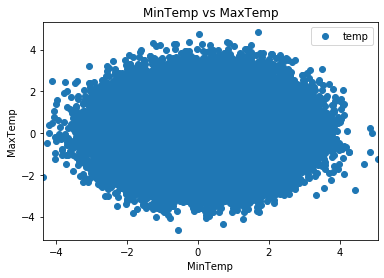

In [12]:
df.plot(x='speed', y='temp', style='o')
plt.title('MinTemp vs MaxTemp')
plt.xlabel('MinTemp')
plt.ylabel('MaxTemp')
plt.show()

In [26]:
X1 = df[['speed','temp']].values
y1 = np.zeros(X1.shape[0], dtype=np.int)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

# train iforest detector
clf_name = 'IForest'
clf = IForest()
clf.fit(X1_train)

# get the prediction labels and outlier scores of the training data
y1_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y1_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y1_test_pred = clf.predict(X1_test)  # outlier labels (0 or 1)
y1_test_scores = clf.decision_function(X1_test)  # outlier scores


In [27]:
y1_pred = clf.predict(X1)
xxx, uni = np.unique(y1_pred, return_counts=True)
dict(zip(xxx, uni))

{0: 250009, 1: 27681}

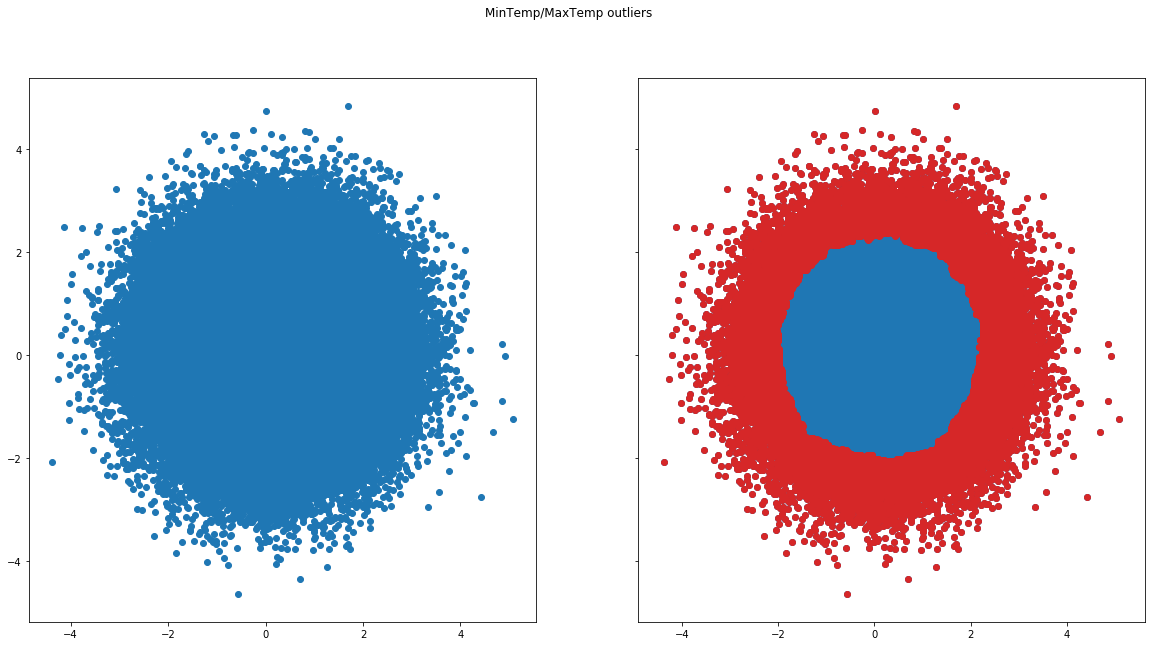

In [28]:
y1_pred = clf.predict(X1)

dfA = df.copy()
dfA['prediction'] = y1_pred

#dfA.plot(x='X1', y='y1', style='o',figsize=(10,7))
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

axs[0].scatter(dfA['speed'], dfA['temp'], color='tab:blue')

axs[1].scatter(dfA['speed'], dfA['temp'], color='tab:blue')
dfB = dfA[~(dfA['prediction'] == 0)]
axs[1].scatter(dfB['speed'], dfB['temp'], color='tab:red')

fig.suptitle('Speed/Temp outliers')  
plt.show()

In [74]:
dataset = pd.read_csv('./anomalyoutput.csv', dtype={"Snowfall":object, "PoorWeather":object, "SNF": object, "TSHDSBRSGF":object})

In [75]:
dataset.describe()

,timestamp,seq,metricTS,Val,SDEV,DELTA,$O-AnomalyIndex,$O-PeerGroup,$O-FieldImpact-1,$O-FieldImpact-2,$O-FieldImpact-3
count,2.396000e+03,2396.000000,2.396000e+03,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,1.561743e+12,100.426127,1.561743e+12,65.053632,0.011034,0.023991,1.000000,1.375209,0.602609,0.270357,0.127034
std,3.928999e+06,60.652513,3.934052e+06,2.799753,0.063316,0.120613,2.966819,0.484278,0.187476,0.148042,0.069042
min,1.561736e+12,0.000000,1.561736e+12,62.279095,0.000000,0.000000,0.138932,1.000000,0.335241,0.002470,0.001202
25%,1.561739e+12,55.000000,1.561739e+12,62.545453,0.003070,0.006782,0.468448,1.000000,0.447770,0.144050,0.082354
50%,1.561743e+12,88.000000,1.561743e+12,63.658517,0.005756,0.012951,0.649597,1.000000,0.546434,0.267352,0.114630
75%,1.561746e+12,138.000000,1.561746e+12,67.830853,0.010950,0.024305,0.734616,2.000000,0.762037,0.424521,0.180240
max,1.561754e+12,238.000000,1.561754e+12,73.045010,1.949464,3.381376,85.240636,2.000000,0.996328,0.475528,0.331459


In [126]:
print (dataset['Val'])
input = dataset['Val'].values

0       73.042150
1       73.040245
2       73.036680
3       63.469444
4       63.689156
5       63.712135
6       63.897790
7       66.008640
8       65.953680
9       66.156950
10      63.869510
11      66.053470
12      66.119540
13      66.131510
14      65.879790
15      66.120316
16      64.385190
17      65.484410
18      65.599730
19      65.204720
20      64.798760
21      65.969950
22      65.046906
23      65.855220
24      64.884260
25      65.456960
26      64.770900
27      63.774868
28      65.811040
29      65.806140
          ...    
2366    63.057380
2367    63.199833
2368    62.916313
2369    63.108330
2370    63.196262
2371    63.136127
2372    63.168827
2373    63.081192
2374    63.112297
2375    63.065205
2376    63.058464
2377    63.155285
2378    63.057198
2379    63.100376
2380    63.132015
2381    63.044720
2382    63.136684
2383    63.137127
2384    63.139885
2385    63.037033
2386    63.119484
2387    63.038544
2388    63.117600
2389    63.042800
2390    63

In [45]:
!pip3 install 'git+https://github.com/tsurubee/banpei.git'

  Cloning https://github.com/tsurubee/banpei.git to /tmp/pip-req-build-b5oun8uj
  Running setup.py bdist_wheel for banpei ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-gqmd2849/wheels/ef/f7/ce/1b667450b12eb638171c15218308e2a6043243696ab114cd2f
Successfully built banpei


In [129]:
import banpei 
model   = banpei.SST(w=100)
results = model.detect(input)

<Figure size 432x288 with 0 Axes>

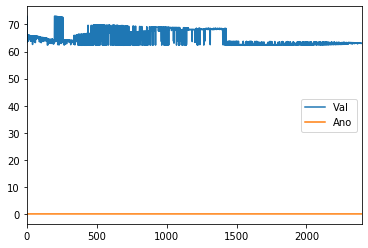

In [130]:
d = {'Val': input , 'Ano' : results}
dfn = pd.DataFrame(data = d)

plt.figure()
dfn.plot()

plt.show()


In [149]:
import tslearn
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape
from tslearn.utils import to_time_series

ts = to_time_series(input)

# all data is training data
X_train = ts #TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(ts)
ks = KShape(n_clusters=8, n_init=1, random_state=0).fit(X_train)

y_pred = ks.fit_predict(X_train)
ks.cluster_centers_.shape

(8, 1, 1)

In [150]:
ks.cluster_centers_.shape

(8, 1, 1)

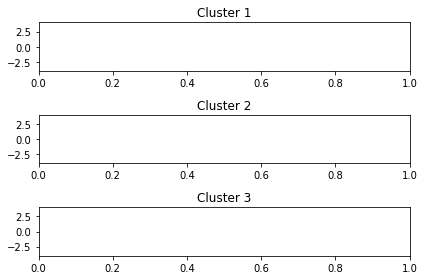

In [147]:
sz = X_train.shape[1]

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()